

### This notebook explores the feature-engineered dataset to identify key patterns in sales performance, pricing, and product characteristics.

---

### 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the feature engineered dataset
df = pd.read_csv("../data/processed/feature_engineered_products.csv", parse_dates=["sale_date", "purchase_date"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    2274 non-null   float64       
 1   sale_date              2273 non-null   datetime64[ns]
 2   purchase_date          2273 non-null   datetime64[ns]
 3   product_description    2395 non-null   object        
 4   manager                2397 non-null   object        
 5   purchase_price_uah     2397 non-null   float64       
 6   sale_price_uah         2393 non-null   float64       
 7   margin_uah             2397 non-null   int64         
 8   missing_sale_date      2397 non-null   bool          
 9   missing_purchase_date  2397 non-null   bool          
 10  missing_sku            2397 non-null   bool          
 11  sale_year              2273 non-null   float64       
 12  usd_rate               2273 non-null   float64       
 13  pur

In [4]:
df["product_category"].value_counts()

product_category
laptop        2058
other          123
console        121
desktop         33
monitor         33
all-in-one      20
camera           7
unknown          2
Name: count, dtype: int64

The analysis focuses exclusively on laptops to ensure comparability across products and avoid mixing fundamentally different device types with distinct pricing and sales dynamics.


In [5]:
# focus on analysis of laptops
df_l = df[df['product_category'] == 'laptop']

### 2. Dataset Overview

In [6]:
# Summary statistics for laptops


summary = {
    "total_laptops": int(len(df_l)),
    "gaming_share": round(float(df_l["is_gaming_laptop"].mean()), 2 ),
    "median_price_usd": round(float(df_l["sale_price_usd"].median()), 2),
    "median_days_on_market": round(int(df_l["days_on_market"].median()), 2)   
}

pd.DataFrame([summary])



,total_laptops,gaming_share,median_price_usd,median_days_on_market
0,2058,0.24,269.63,26


### 3. Visualizations 

### Sales Velocity — Time on Market Distribution

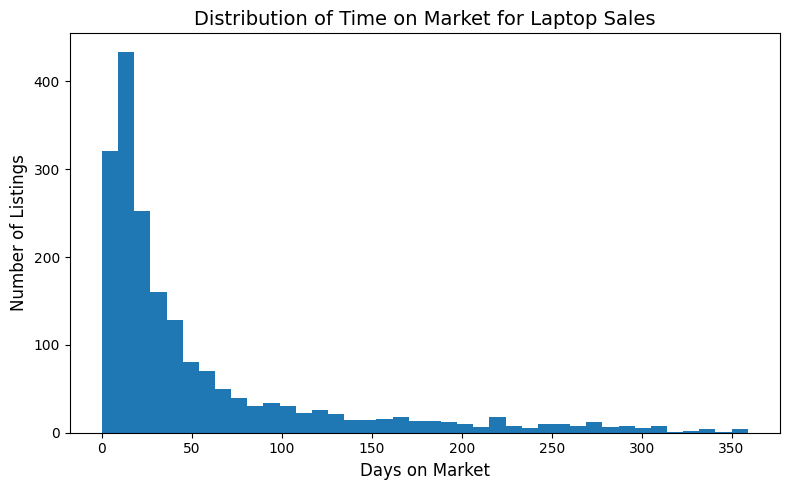

In [7]:

plt.figure(figsize=(8, 5))

plt.hist(
    df_l[df_l["days_on_market"] <= 365]["days_on_market"],
    bins=40
)

plt.title("Distribution of Time on Market for Laptop Sales", fontsize=14)
plt.xlabel("Days on Market", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)

plt.tight_layout()
plt.show()


The distribution of time on market is strongly right-skewed, indicating that most laptops are sold within a relatively short period, while a small number of listings remain active for extended durations.


### Profit Comparison: Gaming vs Non-Gaming Laptops

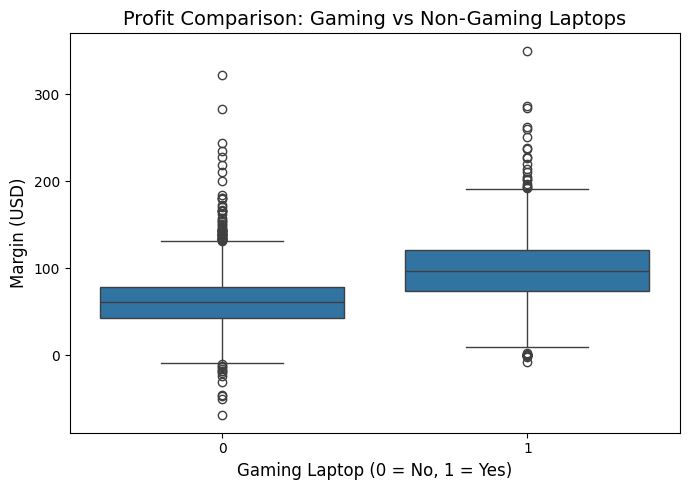

In [8]:

plt.figure(figsize=(7, 5))

sns.boxplot(
    data=df_l,
    x="is_gaming_laptop",
    y="margin_usd"
)

plt.title("Profit Comparison: Gaming vs Non-Gaming Laptops", fontsize=14)
plt.xlabel("Gaming Laptop (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Margin (USD)", fontsize=12)


plt.tight_layout()
plt.show()


Gaming laptops exhibit higher median profit compared to non-gaming models, 
while also showing greater variability in margins.  
This suggests that gaming devices offer higher profit potential but come with increased pricing and demand sensitivity.


### Time on Market: Gaming vs Non-Gaming Laptops

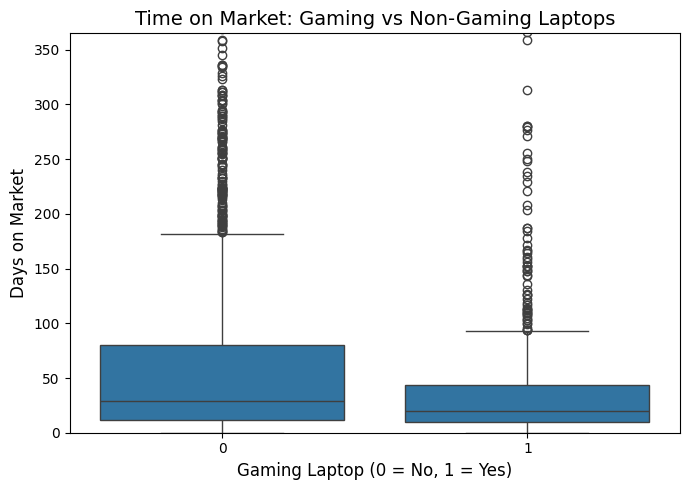

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

sns.boxplot(
    data=df_l,
    x="is_gaming_laptop",
    y="days_on_market"
)

plt.title("Time on Market: Gaming vs Non-Gaming Laptops", fontsize=14)
plt.xlabel("Gaming Laptop (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Days on Market", fontsize=12)

plt.ylim(0, 365)

plt.tight_layout()
plt.show()


Gaming laptops tend to sell faster than non-gaming models, as indicated by a lower median time on market.  
Despite higher price points, demand for gaming devices appears stronger, resulting in improved sales velocity.


### Profit by CPU Vendor (Laptops Only)

In [10]:
# Filter laptops by specific CPU vendors
vendors = ["intel", "amd", "apple"]

df_v = df_l[df_l["cpu_vendor"].isin(vendors)].copy()


In [11]:
# Summary statistics of margin by CPU vendor
df_v.groupby("cpu_vendor")["margin_usd"].describe()

,count,mean,std,min,25%,50%,75%,max
cpu_vendor,,,,,,,,
amd,447.0,77.763032,43.699394,-68.207792,55.538004,74.148148,102.133720,283.116883
apple,11.0,34.558223,45.061636,-7.792208,0.000000,0.000000,78.337662,101.844156
intel,1272.0,71.399370,43.575135,-49.777778,49.404953,67.744749,92.048193,349.397590


Apple-based laptops are included for completeness; however, the small sample size (11 units) limits the reliability of distribution-level comparisons, and results for this group should be interpreted with caution.


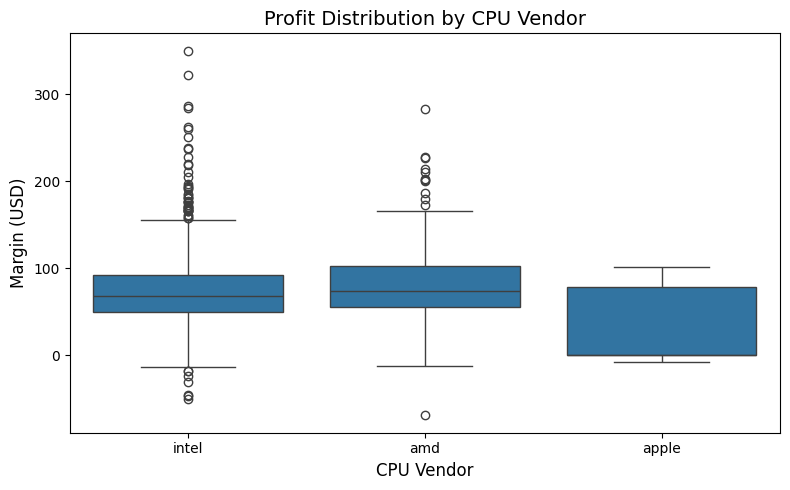

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df_v,
    x="cpu_vendor",
    y="margin_usd"
)

plt.title("Profit Distribution by CPU Vendor", fontsize=14)
plt.xlabel("CPU Vendor", fontsize=12)
plt.ylabel("Margin (USD)", fontsize=12)

plt.tight_layout()
plt.show()


Profitability varies across CPU vendors, with noticeable differences in both median margins and dispersion.  
While Intel-based laptops dominate in volume, AMD and Apple devices exhibit distinct profit profiles, reflecting differences in pricing, demand, and target customer segments.


### Seasonality of Laptop Sales

In [13]:
# Monthly average sales trend for laptops
monthly_by_year = (
    df_l
    .dropna(subset=["sale_month", "sale_year"])
    .groupby(["sale_year", "sale_month"])
    .size()
    .reset_index(name="sales_count")
)

monthly_avg = (
    monthly_by_year
    .groupby("sale_month")["sales_count"]
    .mean()
)



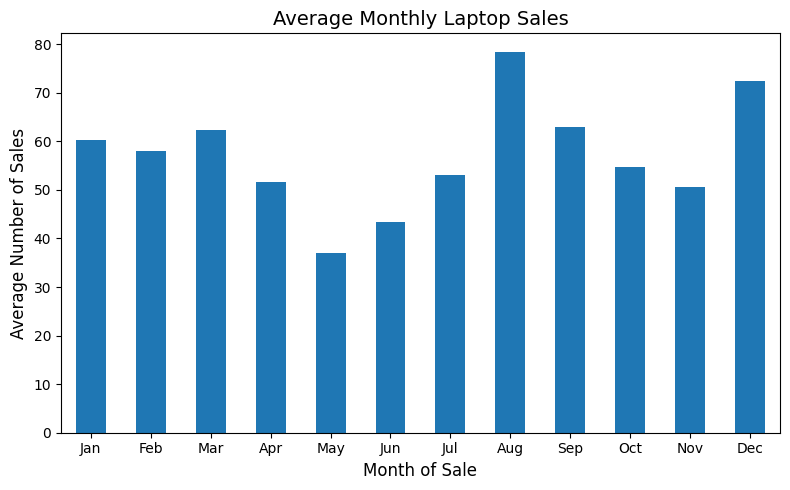

In [14]:
month_labels = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

monthly_avg.plot(kind="bar", figsize=(8, 5))

plt.title("Average Monthly Laptop Sales", fontsize=14)
plt.xlabel("Month of Sale", fontsize=12)
plt.ylabel("Average Number of Sales", fontsize=12)

plt.xticks(
    ticks=range(12),
    labels=month_labels,
    rotation=0
)

plt.tight_layout()
plt.show()

Average monthly sales suggest seasonal variation, with reduced activity in spring and higher demand during late summer and year-end periods.


## Key Findings

- Laptop sales exhibit a strongly right-skewed time-on-market distribution, with a median sale time of approximately one month, while a small number of listings remain active for extended periods.
- Gaming laptops generate higher median profit compared to non-gaming models and tend to sell faster, indicating stronger demand despite higher price points.
- Profitability varies by CPU vendor, reflecting differences in pricing strategies and customer segments; results for Apple devices should be interpreted cautiously due to limited sample size.
- Average monthly sales reveal clear seasonality, with reduced activity during spring months, a peak in late summer, and an additional increase toward year-end.
